In [1]:
import numpy as np
import pandas as pd
import os
import joblib
import pickle
import math
import ast
from scipy.stats import median_abs_deviation, hypergeom, mannwhitneyu
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
# Saving plots with editable text
plt.rcParams['pdf.fonttype'] = 42  # TrueType fonts (editable text)

In [2]:
import dictys
from utils_custom import *
from pseudotime_curves import *
from episode_plots import *
from episodic_dynamics import *
from config import *

In [3]:
config = Config()

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/dynamic.h5')

# Fig 4 - Cell state distributions per fate

#### Get cell state labels for each window

In [5]:
cell_labels = pd.read_csv(config.CELL_LABELS, header=0)
display(cell_labels.index)

RangeIndex(start=0, stop=28494, step=1)

In [6]:
cell_assignment_matrix = dictys_dynamic_object.prop["sc"]["w"]
state_labels_in_window = {}
for window_idx in range(cell_assignment_matrix.shape[0]):
    indices_of_cells_present_in_window = np.where(
        cell_assignment_matrix[window_idx] == 1
        )[0] #these indices start from 0
    state_labels_in_window[window_idx] = [
        cell_labels.iloc[int(idx)]['Cluster'] for idx in indices_of_cells_present_in_window
        ]

In [7]:
state_count_per_window = window_labels_to_count_df(state_labels_in_window)
state_count_per_window = state_count_per_window.drop(index=['ActB-1', 'earlyActB'])

#### Always use pseudotime to bin windows instead of window indices - as pseudotime is the temporal spread/distribution and not the indices

In [8]:
PB_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(98, 147, 1)) + [2]
GC_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(147, 193, 1)) + [3]
PB_post_bifurcation_window_indices = [0] + list(range(98, 147, 1)) + [2]
GC_post_bifurcation_window_indices = [0] + list(range(147, 193, 1)) + [3]

In [9]:
# Define distinct colors for better visibility
colors_cell_count = {
    'ActB-1': '#87CEFA',     # lightskyblue
    'ActB-2': '#1E90FF',     # dodgerblue
    'ActB-3': '#00008B',     # darkblue
    'ActB-4': '#9370DB',     # mediumorchid
    'GC-1': '#7BDE7B',       # custom light green
    'GC-2': '#008000',       # green
    'PB-2': '#BB3636',       # custom red
    'earlyActB': '#008080',   # teal
    'earlyPB': '#F08080'   # lightcoral
}

In [14]:
pseudotime_values_of_windows = AlignTimeScales(dictys_dynamic_object, trajectory_range=[0, 2]).pseudotime_of_windows()

Time points per bin: [15, 17, 3, 3, 4, 3, 5, 1]
Total cells per bin: [np.float64(999.8), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0), np.float64(1000.0)]


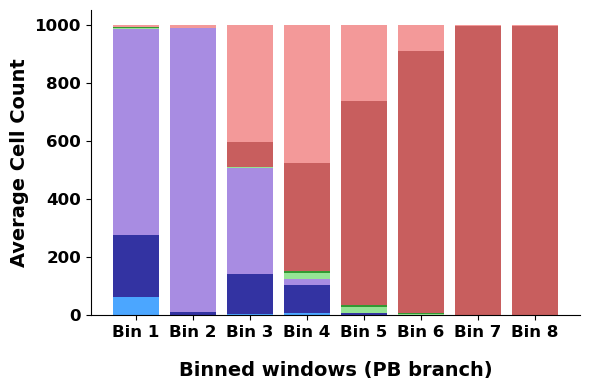

In [15]:
# Create a new dataframe with only the columns in PB_fate_window_indices
df_plot = state_count_per_window[PB_post_bifurcation_window_indices]
# Create time bins
n_bins = 8  # Adjust this number as needed
x = [pseudotime_values_of_windows[i] for i in PB_post_bifurcation_window_indices]
x_min, x_max = min(x), max(x)

# Create bin edges
bin_edges = np.linspace(x_min, x_max, n_bins + 1)
bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(n_bins)]

# Initialize binned data and count time points per bin
binned_data = {state: [0] * n_bins for state in df_plot.index}
bin_counts = [0] * n_bins  # Track how many time points are in each bin

# Aggregate data into bins
for i, time_point in enumerate(x):
    # Find which bin this time point belongs to
    bin_idx = np.digitize(time_point, bin_edges) - 1
    bin_idx = max(0, min(bin_idx, n_bins - 1))  # Ensure within bounds
    
    # Add counts for each cell state to the appropriate bin
    for state in df_plot.index:
        binned_data[state][bin_idx] += df_plot.loc[state].values[i]
    
    bin_counts[bin_idx] += 1

# Average the counts within each bin (so each bin represents average composition)
for state in df_plot.index:
    for bin_idx in range(n_bins):
        if bin_counts[bin_idx] > 0:
            binned_data[state][bin_idx] = binned_data[state][bin_idx] / bin_counts[bin_idx]

# Plot
plt.figure(figsize=(6, 4))
plt.style.use('default')
plt.grid(False)

# Initialize bottom array for stacking
bottom = [0] * n_bins

# Plot each cell state as a layer in the stacked bar
for state in df_plot.index:
    y = binned_data[state]
    plt.bar(range(n_bins), y,
            label=state,
            color=colors_cell_count[state],
            bottom=bottom,
            alpha=0.8)
    
    # Update bottom for next stack layer
    bottom = [bottom[i] + y[i] for i in range(n_bins)]

plt.xlabel('Binned windows (PB branch)', fontsize=14, fontweight='bold', labelpad=15)
plt.ylabel('Average Cell Count', fontsize=14, fontweight='bold')
plt.xticks(range(n_bins), [f"Bin {i+1}" for i in range(n_bins)], fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# save figure
#plt.savefig(os.path.join(output_folder, 'fig4_state_count_PB_bins.pdf'), dpi=1200)
#plt.show()
# Print bin info for verification
print("Time points per bin:", bin_counts)
print("Total cells per bin:", [sum(binned_data[state][i] for state in df_plot.index) for i in range(n_bins)])

# Pseudotime curves of TF expression and activity

In [41]:
exp_curves_dy, exp_curves_dx = SmoothedCurves(dictys_dynamic_object,
    trajectory_range=(0,3),
    num_points=100,
    dist=0.0005,
    sparsity=0.01).get_smoothed_curves(mode="expression")

In [42]:
reg_curves_dy, reg_curves_dx = SmoothedCurves(dictys_dynamic_object,
    trajectory_range=(0,3),
    num_points=100,
    dist=0.0005,
    sparsity=0.01).get_smoothed_curves(mode="regulation")

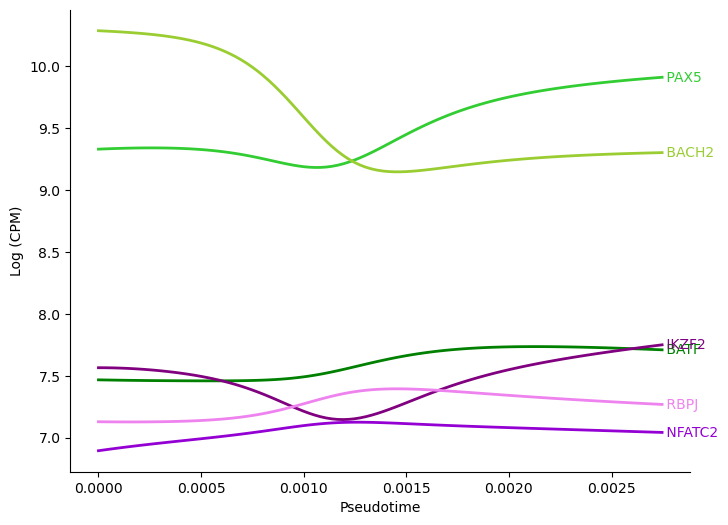

In [55]:
# Plot expression trajectories
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highlight specific genes
#genes_of_interest_pb = ['CREB3L2','RUNX2']
#genes_of_interest_pb = ['IRF4','PRDM1']
#genes_of_interest_pb = ['BACH2','XBP1']
#genes_of_interest_gc = ['IRF4','NFKB1','PRDM1']
#genes_of_interest_gc = ['PAX5','BATF','CREB3L2']
genes_of_interest_gc = ['PAX5','BATF','BACH2','IKZF2','RBPJ','NFATC2']
#colors_pb = ['blueviolet','slateblue']
#colors_pb = ['lightcoral','firebrick']
#colors_pb = ['darkorange','sienna']
#colors_gc = ['blue','dodgerblue','midnightblue']
#colors_gc = ['limegreen','green','olivedrab']
colors_gc = ['limegreen','green','yellowgreen','purple','violet','darkviolet']

for gene, color in zip(genes_of_interest_gc, colors_gc):
    if gene in exp_curves_dy.index:
        line = plt.plot(exp_curves_dx, exp_curves_dy.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(exp_curves_dx.iloc[-1], exp_curves_dy.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('Log (CPM)')
#save the figure
plt.savefig(os.path.join(config.OUTPUT_FOLDER, 'tfs_enriched_in_ko_programs_exp.pdf'), dpi=300)
plt.show()

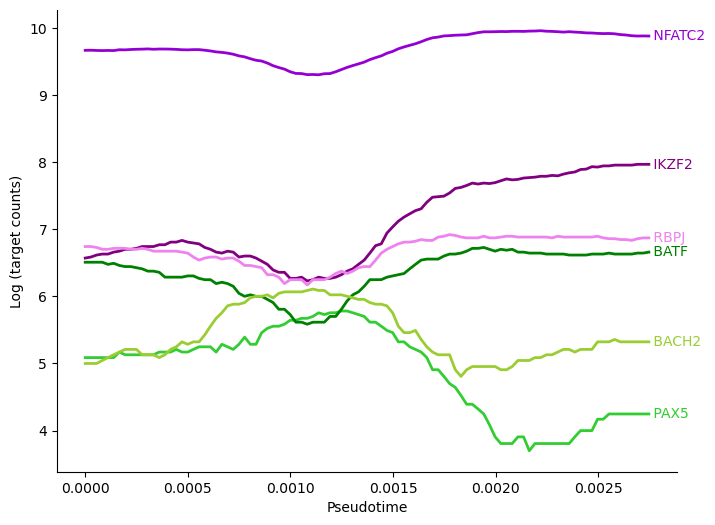

In [56]:
# Plot regulation trajectories
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highlight specific genes
#genes_of_interest_pb = ['CREB3L2','RUNX2']
#genes_of_interest_pb = ['IRF4','PRDM1']
#genes_of_interest_pb = ['BACH2','XBP1']
#genes_of_interest_gc = ['IRF4','NFKB1','PRDM1']
#genes_of_interest_gc = ['PAX5','BATF','CREB3L2']
genes_of_interest_gc = ['PAX5','BATF','BACH2','IKZF2','RBPJ','NFATC2']
#colors_pb = ['blueviolet','slateblue']
#colors_pb = ['lightcoral','firebrick']
#colors_pb = ['darkorange','sienna']
#colors_gc = ['blue','dodgerblue','midnightblue']
#colors_gc = ['limegreen','green','olivedrab']
colors_gc = ['limegreen','green','yellowgreen','purple','violet','darkviolet']

for gene, color in zip(genes_of_interest_gc, colors_gc):
    if gene in reg_curves_dy.index:
        line = plt.plot(reg_curves_dx, reg_curves_dy.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(reg_curves_dx.iloc[-1], reg_curves_dy.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('Log (target counts)')
#save the figure
plt.savefig(os.path.join(config.OUTPUT_FOLDER, 'tfs_enriched_in_ko_programs_reg.pdf'), dpi=300)
plt.show()

# Enriched links

In [74]:
PB_links_plotting = [('RUNX2','PRDM1'),('CREB3L2','RUNX2'),('IRF4','CDK6'),('CREB3L2','FNDC3A'),('CREB3L2','MZB1'),('CREB3L2','TXNDC5'),('TCF12','SEL1L3'),('IRF4','PRDM1'),
                    ('PRDM1','IRF4'),('IRF4','ELL2'),('BACH2','XBP1'),('XBP1','PPIB'),('XBP1','TXNDC11'),('XBP1','HSP90B1'),('CREB3L2','FNDC3B'),('PRDM1','RUNX2')]

In [33]:

GC_links_plotting = [('ARID5B','PIKFYVE'),('ARID5B','PDE4D'),('IRF4','PAX5'),('NFKB1','PAX5'),('IRF4','AFF3'),('NFKB1','AFF3'),('BATF','PPIB'),('BACH2','MZB1'),('PAX5','GLCCI1'),
                     ('PAX5','PRDM1'),('CREB3L2','PAX5')]


#### Initialize pseudotime object

In [75]:
pseudotime_object = SmoothedCurves(dictys_dynamic_object,
    trajectory_range=(0,2),
    num_points=100,
    dist=0.0005,
    sparsity=0.01)

In [76]:
beta_curves, dtime = pseudotime_object.get_beta_curves(PB_links_plotting, varname='w_in')

In [77]:
display(beta_curves)

time_0    time_1    time_2    time_3    time_4    time_5  \
TF      Target                                                                
IRF4    SEL1L3  -0.008434 -0.008043 -0.007606 -0.007128 -0.006618 -0.006080   
        IRF4     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        PPIB    -0.004137 -0.004119 -0.004096 -0.004072 -0.004049 -0.004027   
        XBP1    -0.000549 -0.000467 -0.000391 -0.000320 -0.000253 -0.000190   
        HSP90B1  0.001340  0.001328  0.001278  0.001191  0.001070  0.000918   
...                   ...       ...       ...       ...       ...       ...   
CREB3L2 TXNDC5   0.034675  0.034870  0.034949  0.034913  0.034770  0.034528   
        CDK6     0.001841  0.001703  0.001582  0.001478  0.001390  0.001318   
        ELL2    -0.011655 -0.012004 -0.012355 -0.012705 -0.013052 -0.013395   
        MZB1     0.003484  0.004296  0.005204  0.006210  0.007318  0.008529   
        TXNDC11 -0.006582 -0.006573 -0.006559 -0.006542 -0.006522 -0.006500   

                   time_6    time_7    time_8    time_9  ...   time_90  \
TF      Target                                           ...             
IRF4    SEL1L3  -0.005522 -0.004952 -0.004375 -0.003798  ...  0.004468   
        IRF4     0.000000  0.000000  0.000000  0.000000  ...  0.000000   
        PPIB    -0.004010 -0.004000 -0.003999 -0.004008  ...  0.000562   
        XBP1    -0.000129 -0.000070 -0.000014  0.000039  ...  0.011901   
        HSP90B1  0.000737  0.000531  0.000303  0.000055  ...  0.003145   
...                   ...       ...       ...       ...  ...       ...   
CREB3L2 TXNDC5   0.034196  0.033788  0.033315  0.032791  ...  0.016927   
        CDK6     0.001261  0.001217  0.001184  0.001163  ... -0.012044   
        ELL2    -0.013732 -0.014061 -0.014380 -0.014689  ... -0.003180   
        MZB1     0.009844  0.011264  0.012788  0.014417  ... -0.008599   
        TXNDC11 -0.006476 -0.006450 -0.006424 -0.006396  ... -0.007618   

                  time_91   time_92   time_93   time_94   time_95   time_96  \
TF      Target                                                                
IRF4    SEL1L3   0.003920  0.003353  0.002771  0.002177  0.001573  0.000962   
        IRF4     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        PPIB     0.000180 -0.000182 -0.000524 -0.000846 -0.001148 -0.001430   
        XBP1     0.011652  0.011367  0.011047  0.010694  0.010311  0.009899   
        HSP90B1  0.002037  0.000905 -0.000248 -0.001417 -0.002597 -0.003785   
...                   ...       ...       ...       ...       ...       ...   
CREB3L2 TXNDC5   0.016817  0.016694  0.016555  0.016399  0.016224  0.016029   
        CDK6    -0.012025 -0.011965 -0.011866 -0.011733 -0.011568 -0.011374   
        ELL2    -0.003359 -0.003565 -0.003797 -0.004055 -0.004338 -0.004645   
        MZB1    -0.008556 -0.008507 -0.008450 -0.008386 -0.008312 -0.008230   
        TXNDC11 -0.007146 -0.006645 -0.006118 -0.005566 -0.004992 -0.004400   

                  time_97   time_98   time_99  
TF      Target                                 
IRF4    SEL1L3   0.000348 -0.000266 -0.000880  
        IRF4     0.000000  0.000000  0.000000  
        PPIB    -0.001693 -0.001937 -0.002163  
        XBP1     0.009460  0.008998  0.008513  
        HSP90B1 -0.004977 -0.006170 -0.007360  
...                   ...       ...       ...  
CREB3L2 TXNDC5   0.015814  0.015579  0.015324  
        CDK6    -0.011155 -0.010913 -0.010652  
        ELL2    -0.004976 -0.005328 -0.005701  
        MZB1    -0.008138 -0.008036 -0.007924  
        TXNDC11 -0.003791 -0.003169 -0.002537  

[98 rows x 100 columns]

In [78]:
# get the expression curves of the TFs in the specified links
tf_expression, _ = pseudotime_object.get_smoothed_curves(mode='tf_expression')
regulon_tf_expression = tf_expression.loc[beta_curves.index.get_level_values(0).unique()]

In [79]:
force_curves = pseudotime_object.calculate_force_curves(beta_curves, regulon_tf_expression)

In [80]:
display(force_curves)

time_0    time_1    time_2    time_3    time_4    time_5  \
TF      Target                                                                
IRF4    SEL1L3  -0.304775 -0.298623 -0.291508 -0.283443 -0.274444 -0.264520   
        IRF4     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        PPIB    -0.223689 -0.223304 -0.222812 -0.222263 -0.221706 -0.221192   
        XBP1    -0.093039 -0.086730 -0.080310 -0.073639 -0.066519 -0.058658   
        HSP90B1  0.137099  0.136592  0.134337  0.130308  0.124398  0.116380   
...                   ...       ...       ...       ...       ...       ...   
CREB3L2 TXNDC5   0.505346  0.507504  0.508905  0.509571  0.509536  0.508844   
        CDK6     0.141226  0.136770  0.132698  0.129061  0.125895  0.123225   
        ELL2    -0.314736 -0.319379 -0.323976 -0.328505 -0.332946 -0.337283   
        MZB1     0.186280  0.204402  0.222545  0.240730  0.258962  0.277235   
        TXNDC11 -0.245570 -0.245868 -0.246087 -0.246239 -0.246334 -0.246380   

                   time_6    time_7    time_8    time_9  ...   time_90  \
TF      Target                                           ...             
IRF4    SEL1L3  -0.253677 -0.241912 -0.229201 -0.215498  ...  0.253104   
        IRF4     0.000000  0.000000  0.000000  0.000000  ...  0.000000   
        PPIB    -0.220773 -0.220501 -0.220426 -0.220597  ...  0.102869   
        XBP1    -0.049547 -0.038040 -0.018949  0.029345  ...  0.387352   
        HSP90B1  0.105809  0.091761  0.071881  0.034313  ...  0.217325   
...                   ...       ...       ...       ...  ...       ...   
CREB3L2 TXNDC5   0.507547  0.505710  0.503405  0.500710  ...  0.423609   
        CDK6     0.121058  0.119385  0.118183  0.117418  ... -0.365402   
        ELL2    -0.341498 -0.345577 -0.349508 -0.353280  ... -0.204937   
        MZB1     0.295534  0.313844  0.332146  0.350423  ... -0.315658   
        TXNDC11 -0.246387 -0.246359 -0.246299 -0.246208  ... -0.299478   

                  time_91   time_92   time_93   time_94   time_95   time_96  \
TF      Target                                                                
IRF4    SEL1L3   0.239120  0.223437  0.205668  0.185177  0.160787  0.129886   
        IRF4     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        PPIB     0.062800 -0.062975 -0.099747 -0.122819 -0.140225 -0.154263   
        XBP1     0.383788  0.379656  0.374954  0.369682  0.363838  0.357419   
        HSP90B1  0.179961  0.126486 -0.072101 -0.153658 -0.199907 -0.235422   
...                   ...       ...       ...       ...       ...       ...   
CREB3L2 TXNDC5   0.422638  0.421509  0.420194  0.418672  0.416923  0.414935   
        CDK6    -0.365345 -0.364738 -0.363617 -0.362015 -0.359966 -0.357501   
        ELL2    -0.209968 -0.215570 -0.221673 -0.228209 -0.235111 -0.242316   
        MZB1    -0.315146 -0.314521 -0.313769 -0.312877 -0.311834 -0.310630   
        TXNDC11 -0.291438 -0.282532 -0.272696 -0.261851 -0.249889 -0.236658   

                  time_97   time_98   time_99  
TF      Target                                 
IRF4    SEL1L3   0.083533 -0.074353 -0.124876  
        IRF4     0.000000  0.000000  0.000000  
        PPIB    -0.165982 -0.175968 -0.184592  
        XBP1     0.350422  0.342841  0.334666  
        HSP90B1 -0.265127 -0.291029 -0.314171  
...                   ...       ...       ...  
CREB3L2 TXNDC5   0.412696  0.410198  0.407436  
        CDK6    -0.354650 -0.351444 -0.347913  
        ELL2    -0.249766 -0.257408 -0.265193  
        MZB1    -0.309256 -0.307703 -0.305966  
        TXNDC11 -0.221944 -0.205424 -0.186586  

[98 rows x 100 columns]

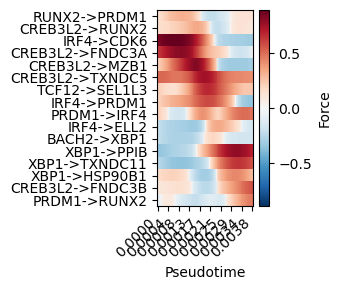

In [81]:
row_scaling = {
    ('NFKB1', 'AFF3'): 0.4  # Scale this GC link to x% of its original values
}

df_plot = force_curves.loc[PB_links_plotting]

force_df_for_cluster, reg_labels, dtime, fig = plot_force_heatmap_with_clustering(
    force_df=df_plot,
    dtime=dtime,
    regulations=PB_links_plotting,
    cmap='RdBu_r',
    vmax=None,
    figsize= (3.5, 3),
    plot_figure=True,
    perform_clustering=False,
    row_scaling=None
)
plt.yticks(fontsize=10)
plt.tight_layout()
# plt.savefig(os.path.join(config.OUTPUT_FOLDER, 'enriched_links_GC.pdf'), 
#             bbox_inches='tight', 
#             dpi=300,
#             format='pdf')
plt.show()

# Fig 5/6 - Episodic enrichment plots
### Direct effect enrichment 

In [27]:
df_ep1 = pd.read_csv(config.ETS1_ALL['ep1'])
df_ep2 = pd.read_csv(config.ETS1_ALL['ep2'])
df_ep3 = pd.read_csv(config.ETS1_ALL['ep3'])
df_ep4 = pd.read_csv(config.ETS1_ALL['ep4'])
df_ep5 = pd.read_csv(config.ETS1_ALL['ep5'])
df_ep6 = pd.read_csv(config.ETS1_ALL['ep6'])
# df_ep7 = pd.read_csv(config.IKZF1_ALL['ep7'])
# df_ep8 = pd.read_csv(config.IKZF1_ALL['ep8'])

Filtered to 69 TFs that meet gene count criteria
Further filtered to 9 TFs that meet significance threshold < 0.004


/ocean/projects/cis240075p/asachan/bio_informatics_analysis/B_Cells_human_analysis/src/multiome_dynamic_regulation/py_scripts/analysis/episode_plots.py:420: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


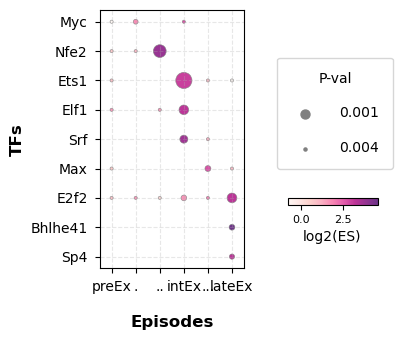

In [31]:
# TF order

#custom_tf_order_prdm1 = ['BPTF', 'SP1', 'BATF3', 'RBPJ', 'IKZF2']
#custom_tf_order_irf4 = ['MBD2', 'IKZF2', 'RBPJ', 'TCF12', 'BACH1', 'HMG20A']
#episode_labels=['ActB1/2', '.', '..', 'ActB3/4', '...', '....', '.....', 'lateGC']

# custom_tf_order_ets1_sig = ['Hdac2', 'Nfkb1', 'Ets1', 'Sin3a', 'Max']
#custom_tf_order_ikzf1_all = ['Ep300', 'E2f2', 'Klf6', 'Nfe2', 'Taf1', 'Nr4a2', 'Bhlhe40', 'Rad21', 'Klf2', 'Ctcf']
custom_tf_order_ets1_all = ['Myc', 'Nfe2', 'Ets1', 'Elf1', 'Srf', 'Max', 'E2f2', 'Bhlhe41', 'Sp4']
episode_labels=['preEx', '.', '..', 'intEx', '...', 'lateEx']

# custom_tf_order_z11_pb = ['CREB3L2', 'MEF2C', 'TFEC', 'TEAD2', 'IRF8', 'IRF9']
# custom_tf_order_z11_gc = ['IKZF3', 'USF2', 'IRF7', 'MEF2C', 'CDC5L', 'POU2F1']

# Use it in the plot
fig, plot_data, plotted_tfs = plot_tf_episodic_enrichment_dotplot(
    dfs=[df_ep1, df_ep2, df_ep3, df_ep4, df_ep5, df_ep6],
    episode_labels=episode_labels,
    figsize=(4.5, 3.5), #breadth by length
    p_value_threshold=0.004,
    min_significance_threshold=0.004,
    min_dot_size=10,    
    max_dot_size=200,   
    cmap_name="RdPu",
    tf_order=custom_tf_order_ets1_all,
    figure_title=None,
    log_scale=True,
    horizontal_layout=False
)
# save the plot
fig.savefig(os.path.join(config.OUTPUT_FOLDER, "ets1_ee.pdf"), dpi=300)

# Ext. Fig - Chromatin level TF activity over pseudotime

In [6]:
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from functools import partial

def process_single_window(i, tfs, base_path):
    """
    Process a single window file and extract TF scores and counts.
    
    Parameters:
    -----------
    i : int
        Window index (1-194)
    tfs : list
        List of TFs to query
    base_path : str
        Base path to the binding.tsv.gz files
    
    Returns:
    --------
    tuple : (window_index, score_dict, count_dict)
    """
    try:
        # Read the binding file
        df = pd.read_csv(
            f'{base_path}/Subset{i}/binding.tsv.gz', 
            sep='\t', 
            compression='gzip'
        )
        df[['chr', 'start', 'end']] = df['loc'].str.split(':', expand=True)
        
        # Initialize results for this window
        window_scores = {}
        window_counts = {}
        
        # Process each TF
        for tf in tfs:
            tf_df = df[df['TF'] == tf]
            
            if not tf_df.empty:
                # Calculate mean score across chromosomes
                median_score = tf_df.groupby('chr').agg({'score': 'mean'}).mean().values[0]
                window_scores[tf] = median_score
                
                # Calculate mean count across chromosomes
                count_score = tf_df.groupby('chr').agg({'score': 'count'}).mean().values[0]
                window_counts[tf] = count_score
            else:
                # TF not found in this window
                window_scores[tf] = float('nan')
                window_counts[tf] = 0
        
        return (i, window_scores, window_counts)
    
    except Exception as e:
        print(f"Error processing window {i}: {e}")
        # Return NaN/0 for all TFs if file fails
        return (i, {tf: float('nan') for tf in tfs}, {tf: 0 for tf in tfs})

def multiprocess_tf_binding_data(tfs, base_path, n_windows=194, n_processes=None):
    """
    Multiprocess the extraction of TF binding data across all windows.
    
    Parameters:
    -----------
    tfs : list
        List of TFs to query
    base_path : str
        Base path to the tmp_dynamic folder
    n_windows : int
        Number of windows to process (default: 194)
    n_processes : int or None
        Number of processes to use (default: None uses all CPUs)
    
    Returns:
    --------
    tuple : (score_dict, count_dict)
        Dictionaries with TF -> list of values across windows
    """
    # Initialize result dictionaries
    score = {tf: [None] * n_windows for tf in tfs}
    count = {tf: [None] * n_windows for tf in tfs}
    
    # Determine number of processes
    if n_processes is None:
        n_processes = max(1, cpu_count() - 1)  # Leave one CPU free
    
    print(f"Processing {n_windows} windows using {n_processes} processes...")
    
    # Create partial function with fixed arguments
    process_func = partial(process_single_window, tfs=tfs, base_path=base_path)
    
    # Process windows in parallel
    with Pool(processes=n_processes) as pool:
        results = list(tqdm(
            pool.imap(process_func, range(1, n_windows + 1)),
            total=n_windows,
            desc="Processing windows"
        ))
    
    # Collect results
    for window_idx, window_scores, window_counts in results:
        for tf in tfs:
            score[tf][window_idx - 1] = window_scores[tf]
            count[tf][window_idx - 1] = window_counts[tf]
    
    return score, count

In [5]:
# list static and episodic TFs
static_tfs = ['PRDM1',
    'PAX5',
    'BACH2',
    'ARID5B',
    'IRF4',
    'IRF8']

episodic_tfs = ['MEF2C',
    'MAX',
    'USF2',
    'MEF2A',
    'IRF1',
    #'IKZF3',
    'POU2F1',
    'TEAD2',]
    #'IRF7']

all_tfs = list(set(static_tfs + episodic_tfs))

base_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/tmp_dynamic'

# Process all TFs
score, count = multiprocess_tf_binding_data(
    tfs=all_tfs,
    base_path=base_path,
    n_windows=194,
    n_processes=None  # Use all available CPUs
)

# You can now access results by category
print(f"\nStatic TFs: {static_tfs}")
print(f"Episodic TFs: {episodic_tfs}")

# Example: Get scores for static TFs only
static_scores = {tf: score[tf] for tf in static_tfs}
episodic_scores = {tf: score[tf] for tf in episodic_tfs}

# # Example: Get counts for episodic TFs only
# static_counts = {tf: count[tf] for tf in static_tfs}
# episodic_counts = {tf: count[tf] for tf in episodic_tfs}

NameError: name 'multiprocess_tf_binding_data' is not defined

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Helper functions
def _to_float(v):
    if hasattr(v, "values"):
        arr = v.values
        if len(arr) == 0:
            return np.nan
        return arr[0]
    return float(v)

def order_series(series, idx_order):
    return np.array([series[i] if i < len(series) else np.nan for i in idx_order], dtype=float)

def smooth(series, sigma=2):
    return gaussian_filter1d(series, sigma=sigma)

# Your indices (unchanged)
PB_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(98, 147, 1)) + [2]
GC_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(147, 193, 1)) + [3]
PB_post_bifurcation_window_indices = [0] + list(range(98, 147, 1)) + [2]
GC_post_bifurcation_window_indices = [0] + list(range(147, 193, 1)) + [3]

x_pb = np.arange(1, len(PB_post_bifurcation_window_indices) + 1)
x_gc = np.arange(1, len(GC_post_bifurcation_window_indices) + 1)

# General processing function—count is a dict: count[tf]=[series_or_scalar, ...] for each TF
def process_tf_data(count, tfs, idx_pb, idx_gc, order=True, smooth_sigma=1):
    series_pb, series_gc = {}, {}
    for tf in tfs:
        vals = [(_to_float(v)) for v in count.get(tf, [])]
        series_pb[tf] = smooth(order_series(vals, idx_pb), sigma=smooth_sigma) if order else np.array(vals)
        series_gc[tf] = smooth(order_series(vals, idx_gc), sigma=smooth_sigma) if order else np.array(vals)
    return series_pb, series_gc

series_pb, series_gc = process_tf_data(
    count, all_tfs, PB_post_bifurcation_window_indices, GC_post_bifurcation_window_indices, order=True, smooth_sigma=2
)

In [ ]:
! plotly_get_chrome


Plotly will install a copy of Google Chrome to be used for generating static images of plots.
Chrome will be installed at: None
Do you want to proceed? [y/n] 

In [ ]:
import numpy as np
import plotly.graph_objects as go

# 1. Get pseudotime values for all windows
# For PB trajectory (range 1-2)
aligner_pb = AlignTimeScales(
    dictys_dynamic_object=dictys_dynamic_object,
    trajectory_range=(1, 2),  # PB trajectory
    num_points=40,
    dist=0.001,
    sparsity=0.01,
    total_episodes=8
)
window_pseudotimes_pb = aligner_pb.pseudotime_of_windows()

# For GC trajectory (range 1-3)
aligner_gc = AlignTimeScales(
    dictys_dynamic_object=dictys_dynamic_object,
    trajectory_range=(1, 3),  # GC trajectory
    num_points=40,
    dist=0.001,
    sparsity=0.01,
    total_episodes=8
)
window_pseudotimes_gc = aligner_gc.pseudotime_of_windows()

# 2. Map window indices to pseudotime values
def get_pseudotimes_for_indices(window_indices, window_pseudotimes):
    """Map window indices to their corresponding pseudotime values"""
    return np.array([window_pseudotimes[idx] for idx in window_indices])

# Get pseudotime x-axes
x_pb_pseudotime = get_pseudotimes_for_indices(PB_post_bifurcation_window_indices, window_pseudotimes_pb)
x_gc_pseudotime = get_pseudotimes_for_indices(GC_post_bifurcation_window_indices, window_pseudotimes_gc)

# 3. TF colors and categories
tf_colors = {
    'PRDM1': '#2E86AB',      # Deep blue
    'PAX5': '#4EA5D9',       # Sky blue
    'BACH2': '#7209B7',      # Royal purple
    'ARID5B': '#9D4EDD',     # Bright purple
    'IRF4': '#06A77D',       # Teal
    'IRF8': '#14746F',       # Deep teal
    
    'MEF2C': '#E63946',      # Red
    'MAX': '#F77F00',        # Orange
    'USF2': '#FCBF49',       # Golden yellow
    'MEF2A': '#D62828',      # Dark red
    'IRF1': '#F4A261',       # Light orange
    #'IKZF3': '#EF476F',      # Pink
    'POU2F1': '#FF9E00',     # Bright orange
    'TEAD2': '#FFB703',      # Amber
    #'IRF7': '#FB8500',       # Dark orange
}

# Determine TF category
def get_tf_category(tf):
    if tf in static_tfs:
        return "Static"
    elif tf in episodic_tfs:
        return "Episodic"
    return "Unknown"

# 4. Create the plot with pseudotime x-axis
fig = go.Figure()

# Plot static TFs first, then episodic TFs (for legend grouping)
for category, tf_list in [("Static", static_tfs), ("Episodic", episodic_tfs)]:
    for tf in tf_list:
        tf_color = tf_colors.get(tf, "black")
        tf_category = get_tf_category(tf)
        
        # GC (dashed, default bottom axis)
        y_gc = series_gc[tf]
        text_gc = [f"{tf} ({tf_category}) GC<br>pseudotime={pt:.3f}<br>window={w}" 
                   for pt, w in zip(x_gc_pseudotime, GC_post_bifurcation_window_indices)]
        fig.add_trace(go.Scatter(
            x=x_gc_pseudotime,
            y=y_gc,
            mode='lines',
            name=f"{tf}",
            line=dict(
                dash='dash', 
                color=tf_color,
                width=2.5 if tf_category == "Static" else 2  # Thicker lines for static TFs
            ),
            opacity=0.9 if tf_category == "Static" else 0.8,
            hoverinfo='text',
            text=text_gc,
            legendgroup=tf,
            legendgrouptitle_text=category if tf == tf_list[0] else None,  # Add category header
            showlegend=True
        ))
        
        # PB (solid, top axis)
        y_pb = series_pb[tf]
        text_pb = [f"{tf} ({tf_category}) PB<br>pseudotime={pt:.3f}<br>window={w}" 
                   for pt, w in zip(x_pb_pseudotime, PB_post_bifurcation_window_indices)]
        fig.add_trace(go.Scatter(
            x=x_pb_pseudotime,
            y=y_pb,
            mode='lines',
            name=f"{tf}",
            line=dict(
                dash='solid', 
                color=tf_color,
                width=2.5 if tf_category == "Static" else 2
            ),
            opacity=0.9 if tf_category == "Static" else 0.8,
            hoverinfo='text',
            text=text_pb,
            xaxis='x2',
            legendgroup=tf,
            showlegend=False
        ))

fig.update_layout(
    title='Mean TF score per subset (PB: solid, GC: dashed)<br><sub>Static TFs: thicker lines | Episodic TFs: regular lines</sub>',
    xaxis=dict(
        title='GC Pseudotime',
        showline=False,
        showgrid=True,
        linecolor='black',
        ticks='outside',
        showticklabels=True
    ),
    xaxis2=dict(
        title='PB Pseudotime',
        anchor='y',
        overlaying='x',
        side='top',
        showline=False,
        showgrid=True,
        linecolor='black',
        ticks='outside',
        showticklabels=True
    ),
    yaxis=dict(title='score (original log space)'),
    legend=dict(
        orientation='v', 
        x=1.02, 
        y=0.5,
        tracegroupgap=30,  # Space between Static and Episodic groups
        title_text="TF Categories"
    ),
    margin=dict(t=100, r=250),  # Increased for category headers
    plot_bgcolor="rgba(0,0,0,0)",
    paper_bgcolor="rgba(0,0,0,0)",
)

fig.show()

# fig.write_html("tf_dynamics_by_category.html")
fig.write_image("/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/figures/tf_dynamics_by_category.svg", format='svg', width=2000, height=600)

RuntimeError: 

Kaleido requires Google Chrome to be installed.

Either download and install Chrome yourself following Google's instructions for your operating system,
or install it from your terminal by running:

    $ plotly_get_chrome

